In [1]:
!which python

/home/aym-workstation/anaconda3/envs/py3.7/bin/python


In [2]:
import numpy as np
import torch
import torch.nn as neural_network
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets,transforms
import torch.nn.functional as torch_functional
import matplotlib.pyplot as plt

Transforms

In [5]:
transform=transforms.Compose([transforms.ToTensor()])

Get Train, Test Data from Torch Datasets

In [6]:
trainData = datasets.MNIST('data',train=True,download=True,transform=transform)
testData = datasets.MNIST('data',train=False,download=True,transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Important Params

In [13]:
trainLength = len(trainData)
indices = list(range(trainLength))
batchSize=20
validSize=0.2
numWorkers=0

np.random.shuffle(indices)
split = int(np.floor(validSize * trainLength))
trainIdx, valIdx = indices[split:], indices[:split]
trainBatch = SubsetRandomSampler(trainIdx)
valBatch = SubsetRandomSampler(valIdx)

print("Length of training data : ", trainLength)
print("Batch Size : ", batchSize)
print("Validation Size : ", validSize)
print("Val split Size : ", split)

Length of training data :  60000
Batch Size :  20
Validation Size :  0.2
Val split Size :  12000


Declaring Train, Test and Valid Dataloaders

In [19]:
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize,
    sampler=trainBatch, num_workers=numWorkers)
valLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize,
    sampler=valBatch, num_workers=numWorkers)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize,
    num_workers=numWorkers)

print("length of our train, valid and test dataloaders : ", len(trainLoader),len(valLoader),len(testLoader))

length of our train, valid and test dataloaders :  2400 600 500


Define Data iterator

In [20]:
dataIter=iter(trainLoader)
images,labels=dataIter.next()

Visualize Training Data in a Batch

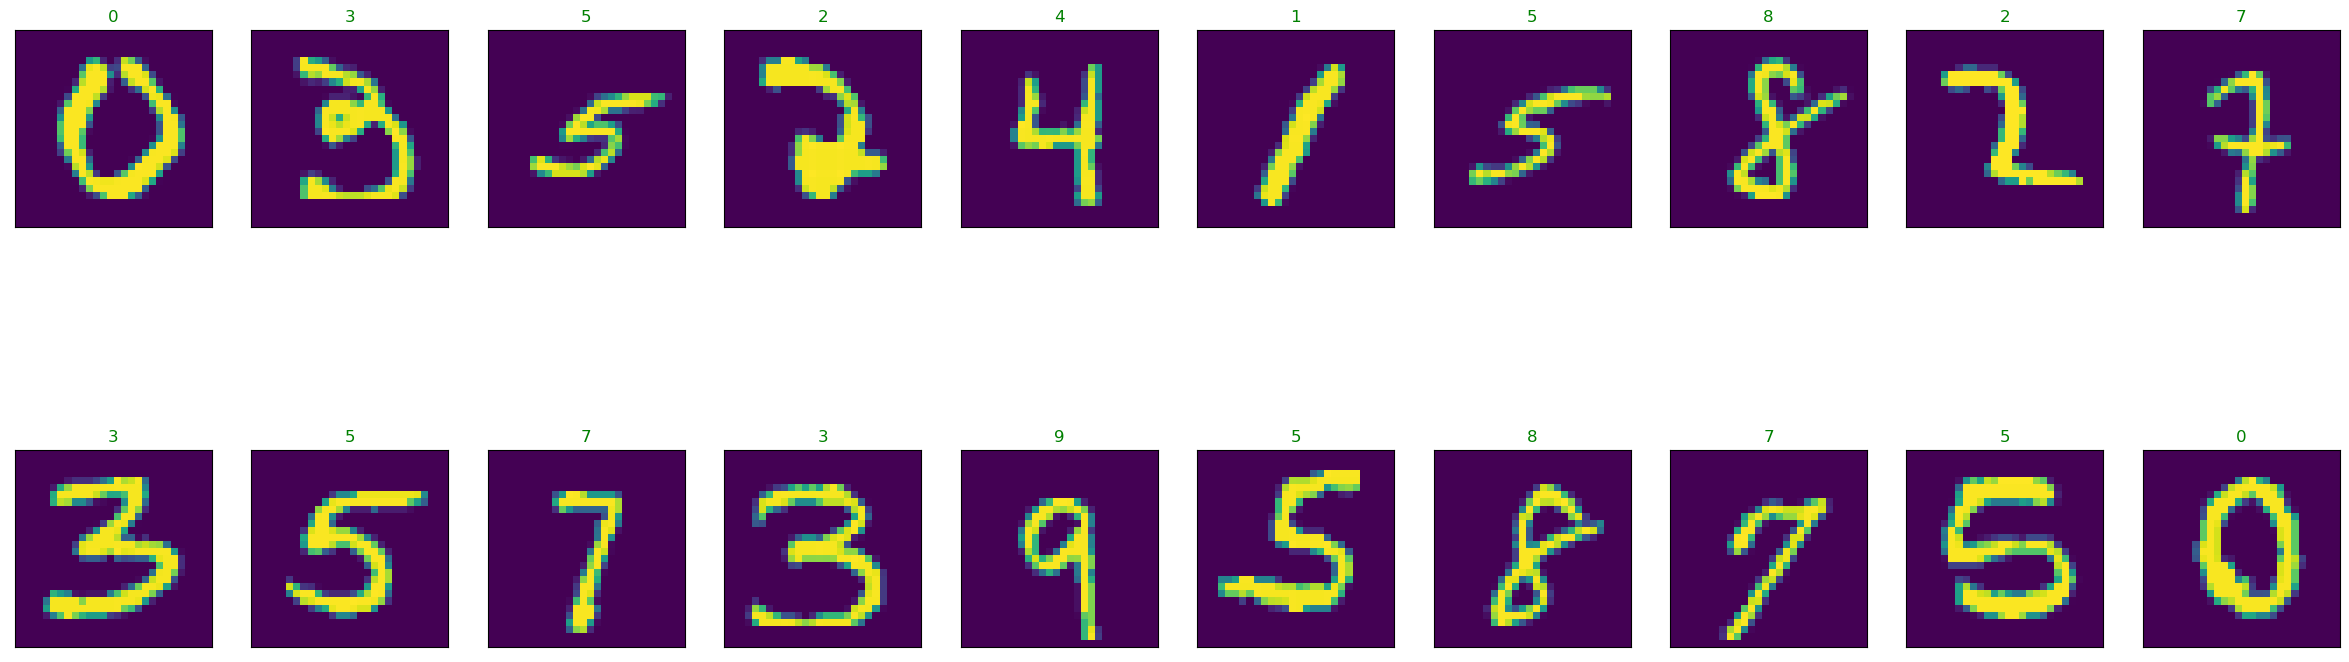

In [21]:
fig = plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(), color='green')

Defining Neural Network Architecture

In [30]:
class ConvNet(neural_network.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.convLayer1 = neural_network.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.convLayer2 = neural_network.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)

    self.fullyConnectedLayer1 = neural_network.Linear(7*7*32,512)
    self.fullyConnectedLayer2 = neural_network.Linear(512,256)
    self.poolLayer = neural_network.MaxPool2d(kernel_size=2,stride=2)
    self.dropoutLayer = neural_network.Dropout(0.2)

    self.outputLayer = neural_network.Linear(256,10)


  def forward(self,x):
    x = self.poolLayer(torch_functional.relu(self.convLayer1(x)))
    x = self.poolLayer(torch_functional.relu(self.convLayer2(x)))
    x = x.view(-1,7*7*32)
    x = self.dropoutLayer(x)
    x = self.dropoutLayer(torch_functional.relu(self.fullyConnectedLayer1(x)))
    x = self.dropoutLayer(torch_functional.relu(self.fullyConnectedLayer2(x)))
    x = self.outputLayer(x)
    return x


def weightInitialization(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

Model = ConvNet()
Model.apply(weightInitialization)

ConvNet(
  (convLayer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convLayer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyConnectedLayer1): Linear(in_features=1568, out_features=512, bias=True)
  (fullyConnectedLayer2): Linear(in_features=512, out_features=256, bias=True)
  (poolLayer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropoutLayer): Dropout(p=0.2, inplace=False)
  (outputLayer): Linear(in_features=256, out_features=10, bias=True)
)

Declare Loss Fxn

In [31]:
criterion = neural_network.CrossEntropyLoss()

Initialize Cuda

In [32]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
  Model.cuda()

print(Model,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

ConvNet(
  (convLayer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convLayer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyConnectedLayer1): Linear(in_features=1568, out_features=512, bias=True)
  (fullyConnectedLayer2): Linear(in_features=512, out_features=256, bias=True)
  (poolLayer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropoutLayer): Dropout(p=0.2, inplace=False)
  (outputLayer): Linear(in_features=256, out_features=10, bias=True)
) 



 On GPU :  False


Training the Network

In [33]:
def trainNet(model,lr, epoch=20):
    lossMap = {'train':[], 'valid':[]}
    epochs = epoch

    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        trainLoss=0.0
        valLoss=0.0

        model.train()

        for imgs,targets in trainLoader:
            if use_cuda and torch.cuda.is_available():
                imgs,targets=imgs.cuda(),targets.cuda()
            optimizer.zero_grad()
            output=model(imgs)
            loss=criterion(output,targets)
            loss.backward()
            optimizer.step()
            trainLoss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval()
        for imgs,targets in valLoader:
            if use_cuda and torch.cuda.is_available():
                imgs,targets = imgs.cuda(),targets.cuda()
            output = model(imgs)
            loss = criterion(output, targets)
            valLoss += loss.item()

        trainLoss = trainLoss/len(trainLoader)
        valLoss = valLoss/len(valLoader)

        lossMap['train'].append(trainLoss)
        lossMap['valid'].append(valLoss)

        print(f"\n No. of epochs : {epoch+1}\tTraining Loss : {trainLoss}\tValidation Loss : {valLoss}")

        if valLoss <= valid_loss_min:
            print(f"Reduction in Validation loss from : {valid_loss_min} ----> {valLoss} ----> Saving Model.......")
            modelName = type(model).__name__
            torch.save(model.state_dict(), modelName + '_model.pth')
            valid_loss_min = valLoss

    return lossMap

In [34]:
modelLoss = trainNet(Model, 0.001)


 No. of epochs : 1	Training Loss : 0.18490694819561515	Validation Loss : 0.05789276638325343
Reduction in Validation loss from : inf ----> 0.05789276638325343 ----> Saving Model.......

 No. of epochs : 2	Training Loss : 0.06821775036054835	Validation Loss : 0.05418702573796812
Reduction in Validation loss from : 0.05789276638325343 ----> 0.05418702573796812 ----> Saving Model.......

 No. of epochs : 3	Training Loss : 0.051258313688231284	Validation Loss : 0.0471721027447984
Reduction in Validation loss from : 0.05418702573796812 ----> 0.0471721027447984 ----> Saving Model.......

 No. of epochs : 4	Training Loss : 0.04238296472327951	Validation Loss : 0.044733950166667
Reduction in Validation loss from : 0.0471721027447984 ----> 0.044733950166667 ----> Saving Model.......

 No. of epochs : 5	Training Loss : 0.03677530362018293	Validation Loss : 0.03476821164184912
Reduction in Validation loss from : 0.044733950166667 ----> 0.03476821164184912 ----> Saving Model.......

 No. of epoch

Loading Saved Model

In [36]:
Model.load_state_dict(torch.load('ConvNet_model.pth'))
print(Model.state_dict)

<bound method Module.state_dict of ConvNet(
  (convLayer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convLayer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fullyConnectedLayer1): Linear(in_features=1568, out_features=512, bias=True)
  (fullyConnectedLayer2): Linear(in_features=512, out_features=256, bias=True)
  (poolLayer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropoutLayer): Dropout(p=0.2, inplace=False)
  (outputLayer): Linear(in_features=256, out_features=10, bias=True)
)>


Plot Training and Validation Loss

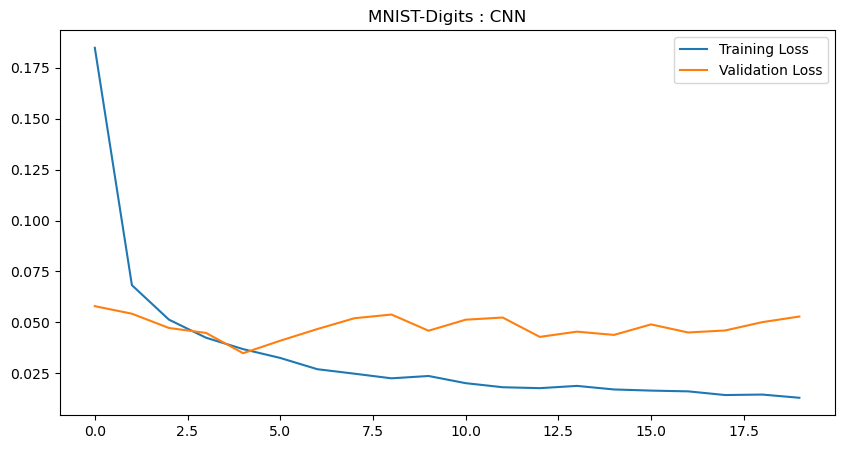

In [37]:
title = ['CNN']
modelLosses=[modelLoss]
fig = plt.figure(1, figsize=(10,5))
idx = 1
ax=fig.add_subplot(1, 1, idx)
ax.plot(modelLoss['train'], label="Training Loss")
ax.plot(modelLoss['valid'], label="Validation Loss")
ax.set_title('MNIST-Digits : CNN')
plt.legend()

Testing Saved Model

In [46]:
def test(model):
    isClassCorrect = list(0. for x in range(10))
    totalClass = list(0. for x in range(10))
    testLoss=0
    model.eval()

    for imgs,targets in testLoader:
        if use_cuda and torch.cuda.is_available():
            imgs,targets = imgs.cuda(), targets.cuda()
        output = model(imgs)
        loss = criterion(output, targets)
        testLoss += loss.item()
        _, pred = torch.max(output,1)
        correct = np.squeeze(pred.eq(targets.data.view_as(pred)))

        for x in range(batchSize):
            label = targets.data[x]
            isClassCorrect[label] += correct[x].item()
            totalClass[label] += 1

    testLoss=testLoss/len(testLoader)
    print(f'Model {type(model).__name__} :')

    for x in range(10):
      if totalClass[x] > 0:
          print(f"Accuracy on Test Data of class {x} : {float(100 * isClassCorrect[x] / totalClass[x])}% in which {int(np.sum(isClassCorrect[x]))} of {int(np.sum(totalClass[x]))} predictions are correct")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (targets[x]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(isClassCorrect) / np.sum(totalClass))}% in which {int(np.sum(isClassCorrect))} of {int(np.sum(totalClass))} predictions are correct")

    dataIterator = iter(testLoader)
    imgs, targets = dataIterator.next()

    if use_cuda and torch.cuda.is_available():
      imgs, targets = imgs.cuda(), targets.cuda()
    output = model(imgs)

    _, predictions = torch.max(output, 1)
    imgs = imgs.cpu().numpy()

    figure = plt.figure(figsize=(25, 4))
    for index in np.arange(20):
        axis = figure.add_subplot(2, int(20/2), index+1, xticks=[], yticks=[])
        axis.imshow(np.squeeze(imgs[index]))
        axis.set_title("{} for ({})".format(str(predictions[index].item()), str(targets[index].item())),
                    color=("blue" if predictions[index]==targets[index] else "red"))

Visualize Test Data Predictions

Model ConvNet :
Accuracy on Test Data of class 0 : 99.79591836734694% in which 978 of 980 predictions are correct
Accuracy on Test Data of class 1 : 99.91189427312776% in which 1134 of 1135 predictions are correct
Accuracy on Test Data of class 2 : 99.70930232558139% in which 1029 of 1032 predictions are correct
Accuracy on Test Data of class 3 : 98.51485148514851% in which 995 of 1010 predictions are correct
Accuracy on Test Data of class 4 : 98.98167006109979% in which 972 of 982 predictions are correct
Accuracy on Test Data of class 5 : 99.43946188340807% in which 887 of 892 predictions are correct
Accuracy on Test Data of class 6 : 97.80793319415449% in which 937 of 958 predictions are correct
Accuracy on Test Data of class 7 : 98.83268482490273% in which 1016 of 1028 predictions are correct
Accuracy on Test Data of class 8 : 99.17864476386038% in which 966 of 974 predictions are correct
Accuracy on Test Data of class 9 : 99.20713577799802% in which 1001 of 1009 predictions are cor

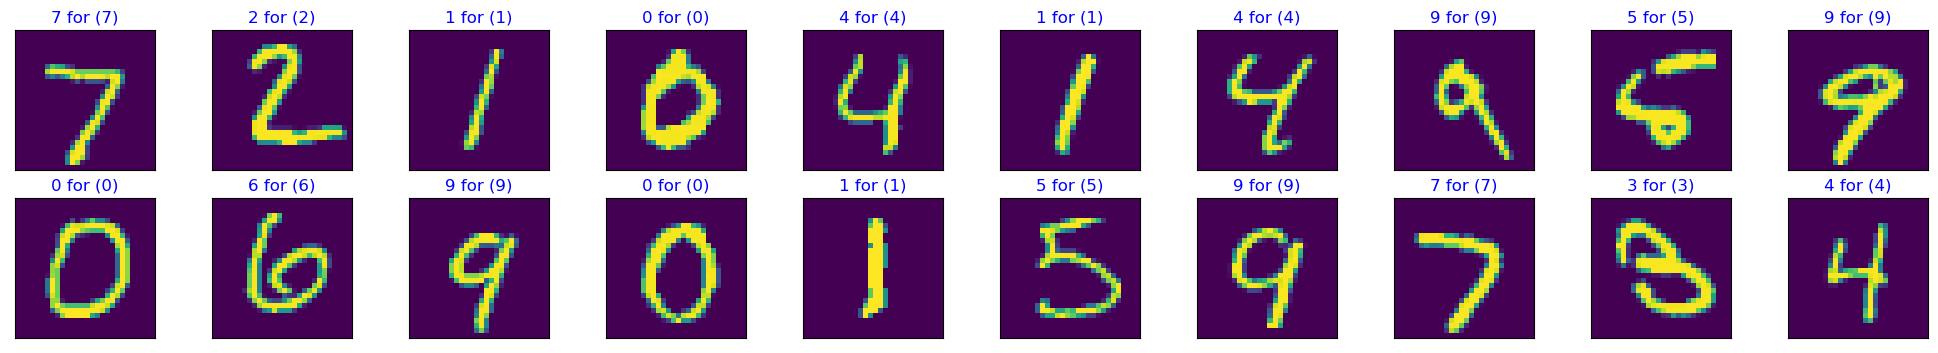

In [47]:
test(Model)